# CS166 First Project - Queuing Theory with a Grocery Store

This Jupyter Notebook consists of several parts. 

* In Part 1 you can find the main part of the code where the system is coded by using OOP.
* In Part 2 you can find a classthat is used to calculate all needed descriptive stats for the empirical analysis.
* In Part 3 you can find the plots we generated. 

In [ ]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    
    Attributes
    ----------
    timestamp: int
        The time in minutes that has passed since the opening of the grocery store. 
    function: func
    *args
        The first argument to any event function is always the schedule in which 
        events are being tracked. 
    **kwargs
        Keyword arguments.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.

        Parameters
        ----------
        other: Event class instance
            An instance of the same class to compare with.
        
        Returns
        -------
        bool
            True if the first event's timestamp is smaller than the second event's 
            ('other'). False, otherwise. 
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.

        Parameters
        ----------
        schedule
            An instance of the Schedule class. 
        '''
        self.function(schedule, *self.args, **self.kwargs)
        
    def __str__(self):
        return f'Event happened at {self.timestamp} with function {self.function.__name__}'


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    
    Attributes
    ----------
    now: int
        The time (in minutes) that has passed since the opening of the store 
        (at 9 a.m.)
    priority_queue: list
        A list that is used as a priority queue of the events based on their 
        order in terms of time. 
    '''
    
    def __init__(self):
        self.now = 0  
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        '''
        This method is used to add events (Even class instance) to the priority 
        queue. 

        Parameters
        ----------
        timestamp: int
            The time at which the event occurs.
        function: function
            The function applied to the event (e.g. start serving sustomer, 
            finish serving customer). 
        
        Returns
        -------
        Doesn't return any values. Pushes a new event to the priority queue of 
        the Schedule instance.
        '''
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
        
    
    def add_event_after(self, interval, function, *args, **kwargs):
        '''
        This method is used to add events (Event class instance) to the priority 
        queue after a specified time interval from the current time, which is 
        expressed with the now attribute of the Schedule instance.

        Parameters
        ----------
        interval: int
            The time interval after which the event occurs.
        function: function
            The function applied to the event (e.g. start serving sustomer, 
            finish serving customer). 
        
        Returns
        -------
        Doesn't return any values. Pushes a new event to the priority queue of 
        the Schedule instance.
        '''
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        '''
        This method returns the time of the next event in the priority queue.

        Parameters
        ----------
        No parameters.
        
        Returns
        -------
        timestamp: int
            Returns the timestamp of the next event in the queue.
        '''
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        '''
        This method runs the next event in the priority queue (the one at the 
        top of the queue with highest priority), updates the current time (now 
        attribute) and runs the event instance by invoking the Event.run() method. 
        
        Parameters
        ----------
        No parameters.
        
        Returns
        -------
        No returns. 
        '''
        # Get next event in line.
        event = heapq.heappop(self.priority_queue)

        # Update the current time.
        self.now = event.timestamp

        # Run the event. 
        event.run(self)
        
    def __repr__(self):
        '''
        This method changes the representation of an object when printed.
        
        Parameters
        ----------
        No parameters.
        
        Returns
        -------
        str
            The representation of the object including the timestamp and number 
            of events in the priority queue. 
        '''
        return (
            f'Schedule() at time {self.now}min ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        '''
        Prints all the events in the priority queue.
        
        Parameters
        ----------
        No parameters.
        
        Returns
        -------
        str
            Each event, including its timestamp and the function name associated 
            with it. 
        '''
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')
            
            
    def __str__(self):
        '''
        This method changes the representation of an object when printed.
        
        Parameters
        ----------
        No parameters.
        
        Returns
        -------
        str
            The representation of the the events in the priority queue as a 
            string.
        '''
        for i in self.priority_queue:
            return str(i)

## Queue and Grocery Store Classes

In [ ]:
import scipy.stats as sts
class Queue_MG1:
    '''
    This class implements an MG1 queue. Each queue is linked with a single server. 
    All cashier queues have information about the manager queue (linked as an 
    instance of this class). 
    
    Attributes
    ----------
    service_distribution: scipy.stats distribution
        The service distribution of the queue. 
    number: int
        The number of the queue from 1 to 10 (since there is a maximum of 10 
        cashiers in total). 
    service_type: str
        The type of queue: 'CASHIER' is it is a normal cashier queue or 'MANAGER' 
        if it is the queue of the (single) manager. 
    manager_queue: instance of the Queue_MG1 class. 
        Points toward the manager queue. If the instance is of sevice_type 
        'MANAGER' this attribute is None. 
    '''
    
    def __init__(self, service_distribution, number, service_type = "CASHIER", manager_queue = None):
        
        ### CHANGED - each queue has a 'name' which is expressed as an integer number
        # In grocery stores cashiers are often linked with numbers so we felt 
        # comforable adding this attribute so it is easier to follow the behavior 
        # of the system (i.e. when printing out the timeline). 
        self.number = number
        
        # Store the deterministic service time for an M/D/1 queue
        self.service_distribution = service_distribution
        
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0
        
        ### CHANGED - added type of queue 'MANAGER' or 'CASHIER'
        self.service_type = service_type
        
        ### CHANGED - each cashier queue points to the queue for the manager
        self.manager_queue = manager_queue
        
        ### CHANGED - add a list to store the arrival, serving, and departure 
        # times for each customer (FIFO so they match)
        self.arrival_times = []
        self.serving_start_times = []
        self.departure_times = []
        
        ### CHANGED - keep track of queue length
        self.max_queue_length = 0

    def add_customer(self, schedule):
        '''
        This method adds a customer as an event to the priority queue. It also 
        checks if there is currently a customer being served at the cashier. If 
        not, the customer being added can be served immediately and an event is 
        added to the schedule to start serving this customer.

        Parameters
        ----------
        schedule: lst
            A priority queue with events.
        
        Returns
        -------
        str
            Prints an overview of the schedule at this timestamp including the length
            of the queue, the type of queue (cashier or manager), the queue ID,
            and the time.
        '''

        # Add the customer to the queue.
        self.people_in_queue += 1
        
        
        ### CHANGED - keep track of maximum queue length
        self.max_queue_length = max(self.max_queue_length,  self.people_in_queue)
        
        
        ### CHANGED - keep track of customer arrival time to the queue
        self.arrival_times.append(schedule.now)
        
        print(
            f'⏱{schedule.now:5.2f}min: Add customer to {self.service_type.lower()} queue.     '
            f' 🧍🏾‍♀️People in the queue #{self.number}: {self.people_in_queue}')
        
        if self.people_being_served < 1:
            # This customer can be served immediately.
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        '''
        This method starts the service of the customer at the front of the queue.
        It also add the finish serving customer event to the queue by generating
        a service time from the N(3, 1) distribution.
        
        Parameters
        ----------
        schedule: lst
            A priority queue with events.
        
        Returns
        -------
        str
            Prints an overview of the schedule at this timestamp including the length
            of the queue, the type of queue (cashier or manager), the queue ID,
            and the time.
        '''
        # Move the customer from the queue to a server.
        self.people_in_queue -= 1
        self.people_being_served += 1
        print(
            f'⏱{schedule.now:5.2f}min: Start serving customer at {self.service_type.lower()}. '
            f' 🧍🏾‍♀️People in the queue #{self.number}: {self.people_in_queue}')
        
        ### CHANGED - keep track of customer serving time to the queue
        self.serving_start_times.append(schedule.now)
        
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        '''
        This method ends the service of a customer. A random probability is
        generated (if it is a cashier queue), if this is smaller than 0.05, 
        the customer is added to the queue for the manager. It also checks in there 
        are any other customers in this specific queue for the cashier, and begins 
        the service of a new customer if so, adding this as an event to the schedule. 
        
        Parameters
        ----------
        schedule: lst
            A priority queue with events.
        
        Returns
        -------
        str
            Prints an overview of the schedule at this timestamp including the length
            of the queue, the type of queue (cashier or manager), the queue ID,
            and the time.
        '''
        # Remove the customer from the server
        self.people_being_served -= 1
        
        print(
            f'⏱{ schedule.now:5.2f}min: Stop serving customer at {self.service_type.lower()}.  '
            f' 🧍🏾‍♀️People in the queue #{self.number}: {self.people_in_queue}')
       
        # If at cashier queue, check if customer moves to manager or leaves
        if self.service_type == 'CASHIER': 
            if np.random.random() < 0.05:
                self.manager_queue.add_customer(schedule)

        ### CHANGED - keep track of customer departure time from the queue
        self.departure_times.append(schedule.now)
                
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)
            
             
class GroceryStore_MG1:
    '''
    This class implements an MG1 queue. Each queue is linked with a single server. 
    All cashier queues have information about the manager queue (linked as an 
    instance of this class). 
    
    Attributes
    ----------
    num_queues: int
        The number of queues in the store (1-10). 
    arrival_distribution: scipy.stats distribution
        The arrival distribution of the customers to the queues. 
    service_distribution: scipy.stats distribution
        The service distribution of the cashier queues. 
    manager_distribution: scipy.stats distribution
        The service distribution of the manager queues. 
    run_until: int
        The time in minutes of the time the store opens (9 a.m.) until the closing 
        time (8 p.m.).
    '''
    
    def __init__(self, num_queues, arrival_distribution, service_distribution, manager_distribution, run_until):
        ### CHANGED
        # Add a manager (queue) to the grocery store. There is a single manager. 
        self.manager_queue = Queue_MG1(manager_distribution, 0, service_type = "MANAGER")
        
        ### CHANGED
        # Initialize the queues as a list of Queue objects. 
        self.queues = []
        for i in range(num_queues):
            self.queues.append(Queue_MG1(service_distribution = service_distribution, 
                                         number = i+1, 
                                         manager_queue = self.manager_queue))
        
        self.arrival_distribution = arrival_distribution
        self.run_until = run_until
        
        self.total_customers = 0
        
    def add_customer(self, schedule):
        '''
        Adds a customer to the shortest queue in self.queues (only if it is before
        the stores closing time). The customer's arrival is added as an event 
        to the schedule by generating their arrival time from Exp(1).
        
        Parameters
        ----------
        schedule: lst
            A priority queue with events.
        
        Returns
        -------
        No returns.
        '''

        ### CHANGED
        if schedule.now <= self.run_until:
            # Add this customer to the shortest queue
            # Intialized current shortest queue.
            shortest_queue = self.queues[0]
            min_people_in_queue = self.queues[0].people_in_queue

            self.total_customers += 1
            
            # Traverse all queues and find the one with the min number of people. 
            for queue in self.queues[1:]:
                if queue.people_in_queue < min_people_in_queue:
                    min_people_in_queue = queue.people_in_queue
                    shortest_queue = queue

            shortest_queue.add_customer(schedule)
            # Schedule when to add another customer
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)

    def run(self, schedule):
        '''
        Adds the arrival of the first customer to the schedule as an event by 
        generating an arrival time from Exp(1).
        
        Parameters
        ----------
        schedule: lst
            A priority queue with events.
        
        Returns
        -------
        No returns.
        '''
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        
### CHANGED
def run_simulation_MG1(num_queues, arrival_distribution, service_distribution, run_until, manager_distribution):
    """ 
    The main function that is used to run the M/G/1 queue simulation with the 
    specified average arrival and cashier and manager service rates, as well as the 
    total time for which to run the simulation and the number of queues in the store.

    Parameters
    ----------
    num_queues: int
        The number of queues in the store (1-10). 
    arrival_distribution: scipy.stats distribution
        The arrival distribution of the customers to the queues. 
    service_distribution: scipy.stats distribution
        The service distribution of the cashier queues. 
    manager_distribution: scipy.stats distribution
        The service distribution of the manager queues. 
    run_until: int
        The time in minutes of the time the store opens (9 a.m.) until the closing 
        time (8 p.m.).
        
    Returns
    -------
    grocery_store: obj
        Schedule for the day, including when customers arrive, are served, and depart,
        as well as other attributes of the grocery_store class.
    """
    schedule = Schedule()
    grocery_store = GroceryStore_MG1(num_queues, arrival_distribution, 
                                     service_distribution, manager_distribution, run_until)
    grocery_store.run(schedule)
    
    # runs while there are events in the priority queue to serve all customers
    while schedule.priority_queue:
        schedule.run_next_event()
        
    return grocery_store

### CHANGED
def run_simulation(num_queues, arrival_distribution, service_distribution, run_until, manager_distribution):
    """ 
    * Function is specifically for the average queue length simulations.
    The main function that is used to run the M/G/1 queue simulation with the 
    specified average arrival and cashier and manager service rates, as well as the 
    total time for which to run the simulation and the number of queues in the store.

    Parameters
    ----------
    num_queues: int
        The number of queues in the store (1-10). 
    arrival_distribution: scipy.stats distribution
        The arrival distribution of the customers to the queues. 
    service_distribution: scipy.stats distribution
        The service distribution of the cashier queues. 
    manager_distribution: scipy.stats distribution
        The service distribution of the manager queues. 
    run_until: int
        The time in minutes of the time the store opens (9 a.m.) until the closing 
        time (8 p.m.).
        
    Returns
    -------
    grocery_store: obj
        Schedule for the day, including when customers arrive, are served, and depart,
        as well as other attributes of the grocery_store class.
    """
    schedule = Schedule()
    grocery_store = GroceryStore_MG1(num_queues, arrival_distribution, 
                                     service_distribution, manager_distribution, run_until)
    grocery_store.run(schedule)
    
    # stops at the end of the duration time (8p.m.)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    
    return grocery_store

## Part 2: Generating the statistics needed for empirical analysis

Here we defined a class `EmpiricalAnalyst` that can calculate any values we need for the graphs.

In [ ]:
import numpy as np
class EmpiricalAnalyst:
    """
    This class calculates the values of different metrics used to determine 
    how many servers should be in the grocery store.

    Attributes
    ----------
    No attributes.
    """

    def calculate_cashier_waiting_time(self, grocery_store):
        """
        This method calculates the average waiting time of customers in one
        grocery store simulation, specifically for the cashier queues and not the
        manager queue.

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        queue_waiting_times: lst
            A list of waiting times for each customer in the simulation.
        """

        # Only waiting time for the cashier queues
        queue_waiting_times = []
        
        for queue in grocery_store.queues:
            waiting_time = [service_start_i - arrival_i for arrival_i, service_start_i 
                            in zip(queue.arrival_times, queue.serving_start_times)]
            queue_waiting_times.append(waiting_time)
            
        return self.flatten_list(queue_waiting_times)

    def calculate_manager_waiting_time(self, grocery_store):
        """
        This method calculates the waiting times of customers in one
        grocery store simulation, specifically for the manager queue and not the 
        cashier queues.

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        queue_waiting_times: lst
            A list of waiting times for each customer that goes to the manager 
            in the simulation.
        """

        # Only waiting time for the manager queue
        queue_waiting_times = [service_start_i - arrival_i for arrival_i, service_start_i 
                               in zip(grocery_store.manager_queue.arrival_times, 
                                      grocery_store.manager_queue.serving_start_times)]

        return queue_waiting_times
    
    def calculate_cashier_response_time(self, grocery_store):
        """
        This method calculates the response times of customers in one
        grocery store simulation, specifically for the cashier queues and not the 
        manager queue. The calculation is simplified as:

        service time = departure - service start
        waiting time = service start - arrival time
        waiting time + service time = departure - arrival

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        response_times: lst
            A list of response times for each customer in the simulation.
        """

        response_times = []
        
        # Response time of each cashier queue.
        for queue in grocery_store.queues:
            response_time = [departure_i - arrival_i for arrival_i, departure_i in 
                             zip(queue.arrival_times, queue.departure_times)]
            
            response_times.append(response_time)
         
        return self.flatten_list(response_times)

    def calculate_manager_response_time(self, grocery_store):
        """
        This method calculates the response times of customers in one
        grocery store simulation, specifically for the manager queue and not the
        cashier queues. The calculation is simplified as:
        
        service time = departure - service start
        waiting time = service start - arrival time
        waiting time + service time = departure - arrival

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        response_times: lst
            A list of response times for each customer in the simulation that goes
            to the manager.
        """   

        # Response time of manager queue.
        response_times = [departure_i - arrival_i for arrival_i, departure_i in 
                                 zip(grocery_store.manager_queue.arrival_times, 
                                     grocery_store.manager_queue.departure_times)]
         
        return response_times
    
    def calculate_max_queue(self, grocery_store):
        """
        This method calculates the maximum queue length for one simulation 
        across all cashier queues.

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        max_queue_length: int
            The maximum queue length for the simulation.
        """

        max_queue_length = 0
        
        for queue in grocery_store.queues:
            max_queue_length = max(max_queue_length, queue.max_queue_length)
            
        return max_queue_length
    
    def calculate_cashier_utilization(self, grocery_store):
        """
        This method returns the average utilisation across all cashier queues in
        a single simulation, where utilization = arrival rate * average service time.

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        utilization: float
            The average utilization of the cashier queues in the simulation.
        """
        # Arrival rate
        arrival_rate = grocery_store.total_customers / grocery_store.run_until

        # Average service time
        service_times = []
        
        for queue in grocery_store.queues:
            service_time = [departure_i - service_start_i for departure_i, service_start_i in 
                            zip(queue.departure_times, queue.serving_start_times)]
            service_times.append(service_time)

        service_times = self.flatten_list(service_times)
        average_service_time = np.mean(service_times) 
        utilization = arrival_rate*average_service_time
        
        return utilization
    
    def calculate_average_queue_length(self, grocery_store):
        """
        This method calculates the average queue length across all n cashier 
        queues in the store (per queue).

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        queue_length: float
            The number of average number of customers across all n queues for each
            queue.
        """
        customers = 0

        # Sum customers left in cashier queues
        for queue in grocery_store.queues:
            customers += queue.people_in_queue

        queue_length = customers/len(grocery_store.queues)

        return queue_length
            
    def calculate_average_system_cashier_customers(self, grocery_store):
        """
        This method calculates the average number of customers in the system 
        (those waiting and being served) across all n cashier queues in the 
        store (per queue).

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        system_size: float
            The number of average number of customers across all n queues (per 
            queue).
        """
        customers = 0

        # Sum customers left in cashier queues and being served 
        for queue in grocery_store.queues:
            customers += queue.people_in_queue
            customers += queue.people_being_served

        system_size = customers/len(grocery_store.queues)

        return system_size

    def calculate_average_customer_waiting_time(self, grocery_store):
      average_cashier_waiting_time = np.mean(self.calculate_cashier_waiting_time(grocery_store))

      if len(self.calculate_manager_waiting_time(grocery_store)) != 0:
        average_manager_waiting_time = np.mean(self.calculate_manager_waiting_time(grocery_store))
      else:
        average_manager_waiting_time = 0
        
      return average_cashier_waiting_time + average_manager_waiting_time

    def calculate_average_customer_response_time(self, grocery_store):
      
      average_cashier_service_time = np.mean(self.calculate_cashier_response_time(grocery_store))

      if len(self.calculate_manager_waiting_time(grocery_store)) != 0:
        average_manager_service_time = np.mean(self.calculate_manager_response_time(grocery_store))
      else:
        average_manager_service_time = 0

      return average_cashier_service_time + average_manager_service_time

    def flatten_list(self, lst):
        """
        This method flattens a nested list.

        Parameters
        ----------
        lst: lst
            A nested list (eg. [[], []]).

        Returns
        -------
        flat_list: lst
            A non-nested list (eg. []).
        """
        # Taken from https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
        flat_list = [item for sublist in lst for item in sublist]
        return flat_list

## Test Cases

In [ ]:
#### ADD MORE TEST CASES HERE!

In [ ]:
# Run the simulation to check it works as expected for a shorter duration and one queue.
import numpy as np

# Exponential with lambda = 1
arrival_distribution = sts.expon(scale = 1) 

# Normal Distribution with mu = 3 and sigma = 1 (standard deviation)
service_time_mean = 3
service_time_variance  = 1**2
service_distribution = sts.truncnorm(loc = service_time_mean, 
                               scale = np.sqrt(service_time_variance), 
                                a = -3, b = float('inf'))

### CHANGED - Add the parameters for the distribution for the manager
# Normal Distribution with mu = 5 and sigma = 2 (standard deviation)
manager_time_mean = 5
manager_time_variance  = 2**2
manager_distribution = sts.truncnorm(loc = manager_time_mean, 
                               scale = np.sqrt(manager_time_variance),
                               a = -2.5, b = float('inf'))

duration = 1*5 # in minutes
num_queues = 1
## run the actual simulation
grocery_store = run_simulation_MG1(num_queues, arrival_distribution, service_distribution, 
                                   duration, manager_distribution)

# Visualize (by printing) number of individuals in each queue
# To check that all customers are served
for queue in grocery_store.queues:
    print(f'\n🔚 At closing time, there are {queue.people_in_queue} people in queue #{queue.number}.')

⏱ 1.42min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱ 1.42min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱ 2.41min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱ 3.01min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 2
⏱ 4.23min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 3
⏱ 4.57min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 3
⏱ 4.57min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 2
⏱ 7.48min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 2
⏱ 7.48min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 1
⏱10.46min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱10.46min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱13.42min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 0
⏱13.42min: Add customer to manager queue.      🧍🏾‍♀️People in th

## Empirical Analysis

In [ ]:
analyst = EmpiricalAnalyst()

# Exponential with lambda = 1
arrival_distribution = sts.expon(scale = 1) 

# Normal Distribution with mu = 3 and sigma = 1 (standard deviation)
service_time_mean = 3
service_time_variance  = 1**2
service_distribution = sts.truncnorm(loc = service_time_mean, 
                               scale = np.sqrt(service_time_variance), 
                               a = -3, b = float('inf'))

### CHANGED - Add the parameters for the distribution for the manager
# Normal Distribution with mu = 5 and sigma = 2 (standard deviation)
manager_time_mean = 5
manager_time_variance  = 2**2
manager_distribution = sts.truncnorm(loc = manager_time_mean, 
                               scale = np.sqrt(manager_time_variance),
                                a = -2.5, b = float('inf'))

duration = 5 # in minutes
num_queues = 7
grocery_store = run_simulation_MG1(num_queues, arrival_distribution, service_distribution, 
                                   duration, manager_distribution)
print(analyst.calculate_cashier_waiting_time(grocery_store))
print(analyst.calculate_manager_waiting_time(grocery_store))
print(analyst.calculate_cashier_response_time(grocery_store))
print(analyst.calculate_manager_response_time(grocery_store))
print(analyst.calculate_max_queue(grocery_store))
print(analyst.calculate_cashier_utilization(grocery_store))

grocery_store = run_simulation(num_queues, arrival_distribution, service_distribution, 
                                   duration, manager_distribution)
print(analyst.calculate_average_queue_length(grocery_store))
print(analyst.calculate_average_system_cashier_customers(grocery_store))
print(analyst.calculate_average_customer_waiting_time(grocery_store))
print(analyst.calculate_average_customer_response_time(grocery_store))

⏱ 0.84min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱ 0.84min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱ 2.10min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱ 4.34min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #2: 1
⏱ 4.34min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #2: 0
⏱ 4.83min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱ 4.83min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱ 7.53min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 0
⏱ 7.68min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #2: 0
[0.0, 2.7321332596826147, 0.0]
[]
[3.994973813424144, 5.435769128070339, 3.3358221651166353]
[]
1
2.006886369385701
⏱ 0.25min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱ 0.25min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱ 0.43min: Add customer to

## Confidence Intervals

### Average Customer Waiting Time and Number of Cashiers

In [ ]:
num_cashiers = [1,2,3,4,5,6,7,8,9,10]
trials = 100
duration = 100

average_waiting_time_per_cashier = []
errors = []

for cashier in num_cashiers:
  average_waiting_times = []

  for i in range(trials):
    grocery_store = run_simulation(cashier, arrival_distribution, service_distribution, duration, manager_distribution)
    all_waiting_times = analyst.calculate_average_customer_waiting_time(grocery_store)
    # all_waiting_times = analyst.calculate_cashier_waiting_time(grocery_store)
    # print(all_waiting_times)
    average_waiting_times.append(np.mean(all_waiting_times))
  
  t = sts.sem(average_waiting_times)
  errors.append(2 * 1.96 * t)

  average_waiting_time_per_cashier.append(np.mean(average_waiting_times))

print(average_waiting_time_per_cashier)
print(errors)

Streaming output truncated to the last 5000 lines.
⏱59.78min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱59.78min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱59.85min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱60.31min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #4: 1
⏱60.64min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #3: 1
⏱60.64min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #3: 0
⏱61.38min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱61.38min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱61.51min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #4: 1
⏱61.51min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #4: 0
⏱61.52min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #2: 1
⏱61.52min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #2: 0
⏱62.34min: Ad

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np

def theoretical_average_waiting_time(num_cashiers):
  values = []
  for cashier in num_cashiers:
    values.append(5/(cashier - 3) + 0.97)
  return values 

def draw_plot(num_cashiers, average_values, errors, label):
    plt.errorbar(num_cashiers, average_values, errors, 
                 color='black', marker='o', capsize=5, linestyle='--', 
                 linewidth=1, label='empirical')
    theoretical_average_values = theoretical_average_waiting_time(num_cashiers[3:])
    plt.plot(num_cashiers[3:], theoretical_average_values, 
             color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
    plt.xlabel('Number of Servers')
    plt.ylabel(label)
    plt.legend()
    plt.show()

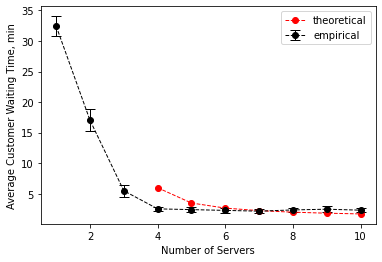

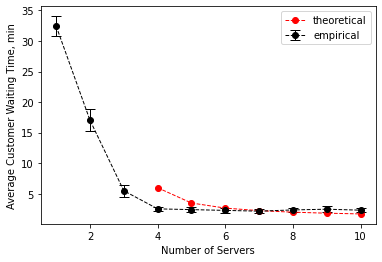

In [ ]:
draw_plot(num_cashiers, average_waiting_time_per_cashier, errors, label = "Average Customer Waiting Time, min")

## Average Customer Response Time and Number of Cashiers

In [ ]:
num_cashiers = [1,2,3,4,5,6,7,8,9,10]
trials = 100
duration = 100

average_response_time_per_cashier = []
errors = []

for cashier in num_cashiers:
  average_response_times = []

  for i in range(trials):
    grocery_store = run_simulation(cashier, arrival_distribution, service_distribution, duration, manager_distribution)
    all_response_times = analyst.calculate_average_customer_response_time(grocery_store)
    average_response_times.append(np.mean(all_response_times))
  
  t = sts.sem(average_response_times)
  errors.append(2 * 1.96 * t)

  average_response_time_per_cashier.append(np.mean(average_response_times))

print(average_response_time_per_cashier)
print(errors)

Streaming output truncated to the last 5000 lines.
⏱190.48min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #3: 0
⏱191.18min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #4: 0
⏱191.61min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱191.61min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱192.17min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱192.20min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #2: 1
⏱192.37min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #3: 1
⏱192.37min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #3: 0
⏱194.15min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #2: 1
⏱194.15min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #2: 0
⏱195.34min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱195.34min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱

In [ ]:
def theoretical_average_response_time(num_cashiers):
  values = []
  for cashier in num_cashiers:
    values.append(3 + 5/(cashier - 3) + 5.97)
  return values 

def draw_plot(num_cashiers, average_values, errors, label):
    plt.errorbar(num_cashiers, average_values, errors, 
                 color='black', marker='o', capsize=5, linestyle='--', 
                 linewidth=1, label='empirical')
    theoretical_average_values = theoretical_average_waiting_time(num_cashiers[3:])
    plt.plot(num_cashiers[3:], theoretical_average_values, 
             color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
    plt.xlabel('Number of Servers')
    plt.ylabel(label)
    plt.legend()
    plt.show()

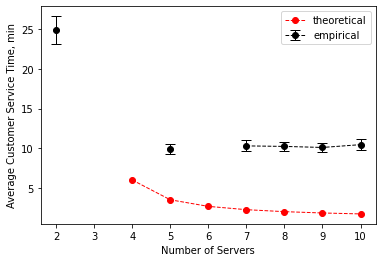

In [ ]:
draw_plot(num_cashiers, average_response_time_per_cashier, errors, label = "Average Customer Service Time, min")

## Maximum Queue Length and Number of Cashiers

In [ ]:
num_cashiers = [1,2,3,4,5,6,7,8,9,10]
trials = 100
duration = 100

average_maximum_queue_length = []
errors = []

for cashier in num_cashiers:
  maximum_queue_lengths = []

  for i in range(trials):
    grocery_store = run_simulation(cashier, arrival_distribution, service_distribution, duration, manager_distribution)
    one_max_length = analyst.calculate_max_queue(grocery_store)
    maximum_queue_lengths.append(one_max_length)
  
  t = sts.sem(maximum_queue_lengths)
  errors.append(2 * 1.96 * t)

  average_maximum_queue_length.append(np.mean(maximum_queue_lengths))

print(average_maximum_queue_length)
print(errors)

Streaming output truncated to the last 5000 lines.
⏱86.70min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 0
⏱86.74min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱86.74min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱87.03min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱88.93min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱88.93min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱89.12min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱89.82min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #2: 1
⏱89.82min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #2: 0
⏱90.20min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #2: 1
⏱90.62min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #3: 1
⏱90.62min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #3: 0
⏱91.74min: Ad

In [ ]:
def draw_plot(num_cashiers, average_values, errors, label):
    plt.errorbar(num_cashiers, average_values, errors, 
                 color='black', marker='o', capsize=5, linestyle='--', 
                 linewidth=1, label='empirical')

    plt.xlabel('Number of Servers')
    plt.ylabel(label)
    plt.legend()
    plt.show()

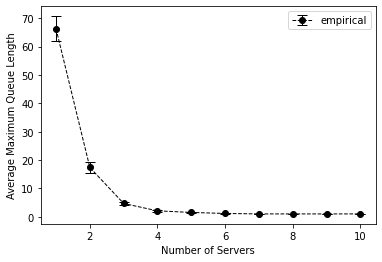

In [ ]:
draw_plot(num_cashiers, average_maximum_queue_length, errors, label = "Average Maximum Queue Length")

## Average Number of People in the System and Number of Cashiers

In [ ]:
num_cashiers = [1,2,3,4,5,6,7,8,9,10]
trials = 100
duration = 100

average_number_people_insystem = []
errors = []

for cashier in num_cashiers:
  number_people_insystem = []

  for i in range(trials):
    grocery_store = run_simulation(cashier, arrival_distribution, service_distribution, duration, manager_distribution)
    one_system = analyst.calculate_average_system_cashier_customers(grocery_store)
    number_people_insystem.append(one_system)
  
  t = sts.sem(number_people_insystem)
  errors.append(2 * 1.96 * t)

  average_number_people_insystem.append(np.mean(number_people_insystem))

print(average_number_people_insystem)
print(errors)

Streaming output truncated to the last 5000 lines.
⏱ 2.95min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #2: 0
⏱ 3.08min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #2: 1
⏱ 5.37min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱ 5.37min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱ 5.85min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #2: 1
⏱ 5.85min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #2: 0
⏱ 6.22min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱ 6.25min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #2: 1
⏱ 6.62min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #3: 1
⏱ 6.62min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #3: 0
⏱ 7.42min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #3: 1
⏱ 9.04min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱ 9.04min: St

In [ ]:
def theoretical_average_people_insystem(num_cashiers):
  values = []
  for cashier in num_cashiers:
    values.append(3 + 5/(cashier - 3))
  return values 

def draw_plot(num_cashiers, average_values, errors, label):
    plt.errorbar(num_cashiers, average_values, errors, 
                 color='black', marker='o', capsize=5, linestyle='--', 
                 linewidth=1, label='empirical')
    theoretical_average_values = theoretical_average_people_insystem(num_cashiers[3:])
    plt.plot(num_cashiers[3:], theoretical_average_values, 
             color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
    plt.xlabel('Number of Servers')
    plt.ylabel(label)
    plt.legend()
    plt.show()

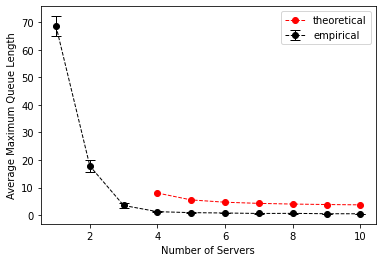

In [ ]:
draw_plot(num_cashiers, average_number_people_insystem, errors, label = "Average Maximum Queue Length")

## Average Queue Length and Number of Cashiers

In [ ]:
num_cashiers = [1,2,3,4,5,6,7,8,9,10]
trials = 100
duration = 100

average_queue_length_per_cashier_size = []
errors = []

for cashier in num_cashiers:
  average_queue_length = []

  for i in range(trials):
    grocery_store = run_simulation(cashier, arrival_distribution, service_distribution, duration, manager_distribution)
    one_average= analyst.calculate_average_queue_length(grocery_store)
    average_queue_length.append(one_average)
  
  t = sts.sem(average_queue_length)
  errors.append(2 * 1.96 * t)

  average_queue_length_per_cashier_size.append(np.mean(average_queue_length))

print(average_queue_length_per_cashier_size)
print(errors)

Streaming output truncated to the last 5000 lines.
⏱83.13min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱83.33min: Stop serving customer at manager.   🧍🏾‍♀️People in the queue #0: 1
⏱83.33min: Start serving customer at manager.  🧍🏾‍♀️People in the queue #0: 0
⏱83.59min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱84.11min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #2: 1
⏱84.11min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #2: 0
⏱85.23min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #1: 1
⏱85.23min: Start serving customer at cashier.  🧍🏾‍♀️People in the queue #1: 0
⏱85.40min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #1: 1
⏱85.44min: Add customer to cashier queue.      🧍🏾‍♀️People in the queue #2: 1
⏱86.11min: Stop serving customer at manager.   🧍🏾‍♀️People in the queue #0: 0
⏱86.37min: Stop serving customer at cashier.   🧍🏾‍♀️People in the queue #2: 1
⏱86.37min: St

In [ ]:
def theoretical_average_response_time(num_cashiers):
  values = []
  for cashier in num_cashiers:
    values.append(5/(cashier*(cashier - 3)))
  return values 

def draw_plot(num_cashiers, average_values, errors, label):
    plt.errorbar(num_cashiers, average_values, errors, 
                 color='black', marker='o', capsize=5, linestyle='--', 
                 linewidth=1, label='empirical')
    theoretical_average_values = theoretical_average_waiting_time(num_cashiers[3:])
    plt.plot(num_cashiers[3:], theoretical_average_values, 
             color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
    plt.xlabel('Number of Servers')
    plt.ylabel(label)
    plt.legend()
    plt.show()

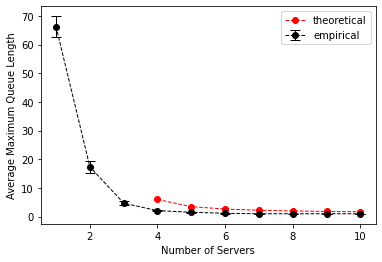

In [ ]:
draw_plot(num_cashiers, average_maximum_queue_length, errors, label = "Average Maximum Queue Length")

## Archives (can delete once we're done)

In [ ]:
    
    def calculate_all_waiting_time(self, grocery_store):
        """
        This method 

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        
        """
        # Waiting time for the cashier queues and the manager queue
        queue_waiting_times = []
        
        # Cashier queues waiting times
        for queue in grocery_store.queues:
            waiting_time = [service_start_i - arrival_i for arrival_i, service_start_i in 
                            zip(queue.arrival_times, queue.serving_start_times)]
            queue_waiting_times.append(waiting_time)
            
        # Manager queue waiting time
        manager_waiting_time = [service_start_i - arrival_i for arrival_i, service_start_i in 
                                 zip(grocery_store.manager_queue.arrival_times, 
                                     grocery_store.manager_queue.serving_start_times)]
        queue_waiting_times.append(manager_waiting_time)
            
        return self.flatten_list(queue_waiting_times)

In [ ]:
    
    def calculate_utilization_per_queue(self, grocery_store):
        """
        This method 

        Parameters
        ----------
        grocery_store: obj
            Schedule for the day, including when customers arrive, are served, and depart,
            as well as other attributes of the grocery_store class.

        Returns
        -------
        
        """
        # utilization (rho) = arrival rate * average service time
        
        # Arrival rate
        arrival_rate = grocery_store.total_customers / grocery_store.run_until
        print("Arrival rate", arrival_rate)
        
        # Average service time
        service_times = []
        
        for queue in grocery_store.queues:
            service_time = [departure_i - service_start_i for departure_i, service_start_i in 
                            zip(queue.departure_times, queue.serving_start_times)]
            service_times.append(service_time)
            
            
        service_times = self.flatten_list(service_times)
        
        
        import numpy as np
        average_service_time = np.mean(service_times) 
        
        utilization = arrival_rate*average_service_time
        
        return utilization

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(-1, 7, 500)
y = sts.truncnorm(loc = 3, scale = 1, a = -3, b = float('inf')).pdf(x)
plt.plot(x, y)
plt.show()

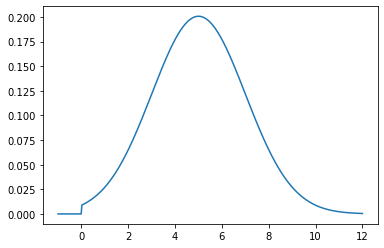

In [ ]:


x = np.linspace(-1, 12, 500)
y = sts.truncnorm(loc = 5, scale = 2, a = -2.5, b = float('inf')).pdf(x)
plt.plot(x, y)
plt.show()